In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import datetime

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures,OneHotEncoder

from sklearn.model_selection import GridSearchCV, train_test_split, PredefinedSplit

In [2]:
folder_dir = '../data/'
data_path = "data_clean.csv"
data = pd.read_csv(filepath_or_buffer= folder_dir + data_path, header=0)
data=data.drop('Unnamed: 0',axis=1)

data.head()

,date,umpcall,outcome,start_speed,pfx_x,pfx_z,px,pz,break_y,break_angle,...,descr,y,year,zone,strikes,balls,pitcher,pitch_type.1,rolling_start_speed,long_rolling_start_speed
0,2013-06-11,S,NaN,92.5,-4.42,9.88,-0.895,2.039,23.8,24.8,...,Called Strike,1,2013,13,0,1,aardsda01,FF,92.26,91.65
1,2013-06-11,B,NaN,86.5,-6.92,3.89,-1.039,2.379,23.8,21.6,...,Ball,0,2013,13,1,1,aardsda01,FS,92.26,91.65
2,2013-06-11,S,NaN,92.8,-4.97,9.90,-0.314,3.032,23.8,28.2,...,Foul,1,2013,1,1,2,aardsda01,FF,92.46,91.72
3,2013-06-11,S,NaN,82.3,1.82,-3.22,-0.669,3.475,23.9,-5.0,...,Foul,1,2013,1,2,2,aardsda01,SL,92.46,91.72
4,2013-06-11,S,NaN,83.1,1.10,1.02,-0.064,1.347,23.7,-4.5,...,Swinging Strike,1,2013,13,2,2,aardsda01,SL,92.46,91.72


In [3]:
data.shape

(3878118, 25)

In [4]:
data.isnull().any()[data.isnull().any()]

outcome    True
nasty      True
dtype: bool

## Target feature

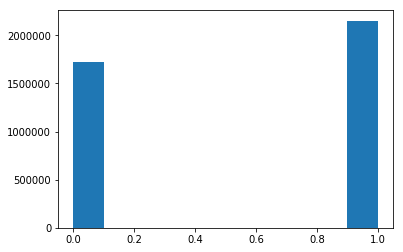

In [5]:
#Using descr feature to define good pitch
g_outcomes=['Foul Tip','Swinging Strike','In play, out(s)', 'Called Strike', 'Foul','Foul (Runner Going)','Foul Bunt',
       'Swinging Strike (Blocked)', 'Missed Bunt' ]

#Using outcome feature to use more detailed descriptions (eg: lineout vs groundout). I think this approach is better
g_outcomes2=['Flyout', 'Fly Out','Groundout','Pop Out','Forceout','Double Play','Grounded into DP','Fielders Choice',
             'Fielders Choice Out','Bunt Groundout','Bunt Pop Out','Sac Fly DP','Bunt Lineout','Foul']

data['y']=np.where((data['outcome'].isin(g_outcomes2)) | (data['umpcall']=='S'),1,0)
a=plt.hist(data['y'])

### Generate batter-pitcher count
##### https://twitter.com/darenw/status/985168614008508416 (cool image)

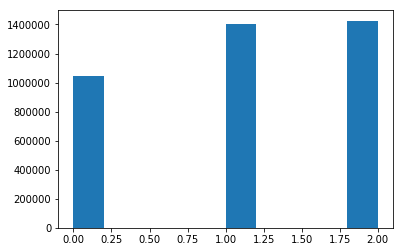

In [6]:
data['count_b_p']=np.where((data['strikes']>data['balls']),2,0)

data['count_b_p']=np.where(((data['strikes']==0) & (data['balls']==0)),1,data['count_b_p'])
data['count_b_p']=np.where(((data['strikes']==1) & (data['balls']==1)),1,data['count_b_p'])

# 2-2 is a pitchers' count
data['count_b_p']=np.where(((data['strikes']==2) & (data['balls']==2)),2,data['count_b_p'])
plt.hist(data.count_b_p);

### One-hot encode zone

In [7]:
data['zone'].unique()

array([13,  1,  5, 14,  8,  3, 11,  4,  9,  6, 12,  2,  7], dtype=int64)

In [8]:
zone=pd.get_dummies(data['zone'],prefix='zone').drop('zone_14',axis=1)
data=pd.concat([data,zone],axis=1).drop('zone',axis=1)

In [9]:
### Create features
data.columns

Index(['date', 'umpcall', 'outcome', 'start_speed', 'pfx_x', 'pfx_z', 'px',
       'pz', 'break_y', 'break_angle', 'break_length', 'pitch_type',
       'spin_dir', 'nasty', 'pitch_count', 'descr', 'y', 'year', 'strikes',
       'balls', 'pitcher', 'pitch_type.1', 'rolling_start_speed',
       'long_rolling_start_speed', 'count_b_p', 'zone_1', 'zone_2', 'zone_3',
       'zone_4', 'zone_5', 'zone_6', 'zone_7', 'zone_8', 'zone_9', 'zone_11',
       'zone_12', 'zone_13'],
      dtype='object')

## Train, test, validation split

In [14]:
#Features to construct random forest
model_feats=['px','pz','start_speed','spin_dir','y']

In [16]:
data["date"] = pd.to_datetime(data["date"])

start = data["date"].searchsorted(datetime.datetime(2012, 1, 1))[0]
#start
end = data["date"].searchsorted(datetime.datetime(2016, 1, 1))[0] - 1
#end

X_train = data[model_feats].loc[start:end]
y_train=X_train['y']
X_train=X_train.drop(['y'],axis=1)

X_test=data[model_feats][end:]
y_test=X_test['y']
X_test=X_test.drop(['y'],axis=1)

In [18]:
X_train.head()

,px,pz,start_speed,spin_dir
0,-0.895,2.039,92.5,204.000
1,-1.039,2.379,86.5,240.369
2,-0.314,3.032,92.8,206.551
3,-0.669,3.475,82.3,29.828
4,-0.064,1.347,83.1,133.996


In [ ]:
#train_index=[-1]*(X_train.shape[0])
#val_index=[0]*(X_val.shape[0])
#ps=PredefinedSplit(test_fold=np.concatenate((train_index,val_index)))

### Random Forest

In [19]:
steps= [('rf', RandomForestClassifier())]

mypipeline= Pipeline(steps)

param_grid_rf = dict(
    #rf__min_samples_leaf= [400],
    #rf__min_samples_split= [1000],
    rf__max_depth= [4],
    rf__n_estimators= [200]
      )

In [20]:
rf_grid_search= GridSearchCV(mypipeline, param_grid = param_grid_rf, scoring ='neg_log_loss',
                                    n_jobs=2, refit=True)

print('Fitting')
rf_grid_search.fit(X_train, y_train)

Fitting


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params=None, iid=True, n_jobs=2,
       param_grid={'rf__max_depth': [4], 'rf__n_estimators': [200]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_log_loss', verbose=0)

In [21]:
best_score= rf_grid_search.best_score_
model=rf_grid_search.best_estimator_.steps[0][1]
print(model, best_score)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False) -0.533673265649


In [22]:
regions=model.apply(X_train)
np.unique(regions)

array([ 4,  5,  7,  8, 11, 12, 14, 15, 19, 20, 22, 23, 26, 27, 29, 30], dtype=int64)

In [26]:
model_feats[:-1]

['px', 'pz', 'start_speed', 'spin_dir']

In [27]:
regions=model.apply(data[model_feats[:-1]])

MemoryError: 

In [ ]:
#Save data with new regions feature
data = pd.concat([data,regions],axis=1)
save_path=folder_dir+'data_clean.csv'
data.to_csv(save_path) 

In [ ]:
Stop=

In [ ]:
# RF Feature Importances
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot the feature importances
fig = plt.figure(figsize=(20,8))
plt.bar(range(len(indices)), importances[indices], color="r", align="center")
plt.title('Feature Importances Bar Plot')
plt.xlabel('Feature Name')
plt.ylabel('Feature Importance')
plt.xticks(range(len(indices)), train_val.drop('Y', axis=1).columns[indices], rotation=45, horizontalalignment='right')
plt.xlim([-1, len(indices)])
plt.title('Feature Importance Graph for RF')
plt.show()
print('\rSaving feature_importances barplot... ', end='')
fig.savefig(rf_dir + 'feature_importances_rf.png')
print('done.')